#### Installing Compatible Package Versions for Medical Image Processing

In [ ]:
# 🚀 Install compatible versions
!pip install numpy==1.23.5
!pip install monai==1.2.0
!pip install SimpleITK==2.2.1
!pip install nibabel==5.1.0
!pip install pydicom==2.4.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
langchain 0.3.19 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 req

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

#### Mounting Google Drive in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from highdicom.seg.sop import Segmentation

## Preparing training and validation data

This prepares file paths for training and validation data by locating NIFTI image and label files for spleen segmentation.

It creates a list of dictionaries, each containing an image file path and its corresponding label file path, and then splits them into training and validation sets.

* Define File Paths: Define structured file paths to keep the code clean and maintainable.
  - data_root: Base directory in Google Drive containing all relevant files.

  - images_dir: Path to the folder containing CT scan images in .nii.gz format.

  - labels_dir: Path to the folder containing corresponding segmentation labels.

  - model_out: Path to save the fine-tuned model after training.

  - pretrained_model_path: Optional path to a pre-trained MONAI model to be used for transfer learning or evaluation.

* Prepare Data List: Collect all image-label pairs for training and validation using glob and a basic filtering loop.
  - glob.glob(...): Searches for all .nii.gz image files.

  - sorted(...): Ensures consistent ordering.

  - For each image:

    - Extracts the case name from the filename.

    - Constructs the expected label path by appending _label.nii.gz.

    - If the label file exists, a dictionary of {image: ..., label: ...} is added to the data_dicts list.

* Split Into Training and Validation Sets
    - train_test_split is used to split the dataset:

        * 75% for training, 25% for validation.

        * random_state=42 ensures reproducibility of the split.

        * shuffle=True helps generalize better by mixing the dataset.





In [ ]:
# ✅ STEP 3: Paths
data_root = "/content/drive/MyDrive/SpleenNifti"
images_dir = os.path.join(data_root, "images")
labels_dir = os.path.join(data_root, "labels")
model_out = os.path.join(data_root, "fine_tuned_spleen_model.pt")
pretrained_model_path = os.path.join(data_root, "spleen_ct_segmentation.pt")  # Optional

# ✅ STEP 4: Prepare Data List
image_paths = sorted(glob.glob(os.path.join(images_dir, "*.nii.gz")))
data_dicts = []
for img in image_paths:
    case = os.path.basename(img).replace(".nii.gz", "")
    label = os.path.join(labels_dir, f"{case}_label.nii.gz")
    if os.path.exists(label):
        data_dicts.append({"image": img, "label": label})

train_percent = 0.75  # 75% train, 25% validation
# Shuffle and split
train_files, val_files = train_test_split(
    data_dicts,
    test_size=(1 - train_percent),
    random_state=42,
    shuffle=True
)
print(f"Total Training Images: {len(train_files)}")
print(f"Total Validation Images: {len(val_files)}")

Total Training Images: 30
Total Validation Images: 11


#### Ensuring Reproducibility with set_determinism:
  * reproducibility is important. To get the same results every time you run your notebook, you need to control randomness.

  * set_determinism is a utility function from MONAI.

  It ensures:

    - Consistent behavior of random number generators (Python, NumPy, PyTorch).

    - Fixed random data augmentations.

    - Deterministic training process.

    - seed=0 sets the base seed for generating pseudo-random numbers.

In [ ]:
set_determinism(seed=0)

# Monai Transforms

- This utilizes different Monai transforms for both training and validation data in medical image analysis.

- The transforms include loading images and labels, ensuring channel-first format, adjusting intensity range, cropping out empty space, orienting the images, adjusting spacing, and performing random cropping based on positive and negative labels for training.

- Validation transforms exclude the random cropping for a consistent evaluation.

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


# Check transforms in DataLoader

This loads a validation dataset, processes the first batch, extracts an image and its corresponding label

In [ ]:
import matplotlib.pyplot as plt

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])

print(f"image shape: {image.shape}, label shape: {label.shape}")
num_slices = image.shape[-1]  # typically the depth (z-axis)

for i in range(num_slices):
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Slice {i}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image[:, :, i], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Label")
    plt.imshow(label[:, :, i], cmap="gray")
    plt.axis("off")

    plt.show()


# Visualzing Intermediate Preprocessing Outputs

It is important to analyze how the intermediate outputs look like.

- This demonstrates various data processing steps for a single validation image.

- It loads, scales pixel intensities, ensures channel-first format, performs intensity scaling, and then crops out the foreground region of the image.

- Intermediate results and histograms are visualized to illustrate the transformations and data characteristics.

torch.Size([512, 512, 87])


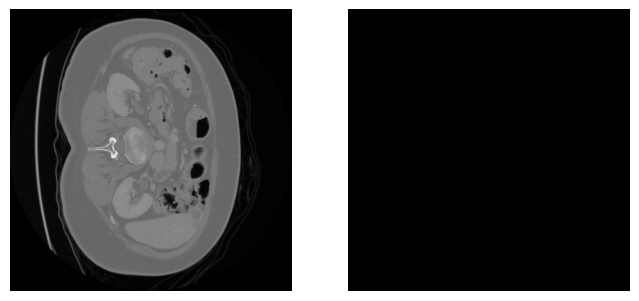

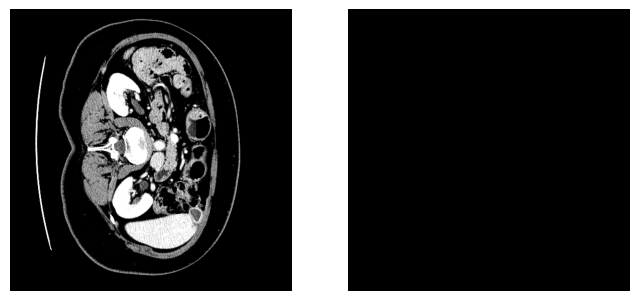

torch.Size([1, 512, 512, 87])


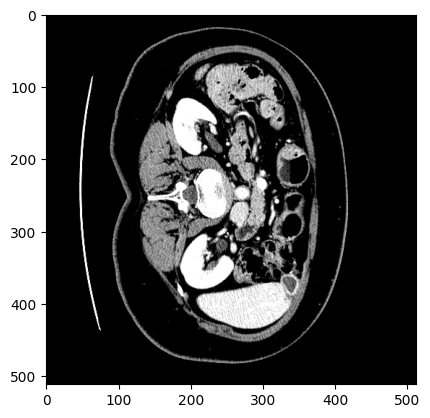

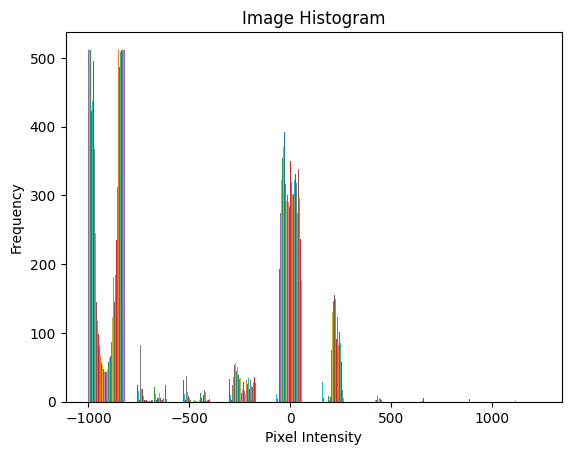

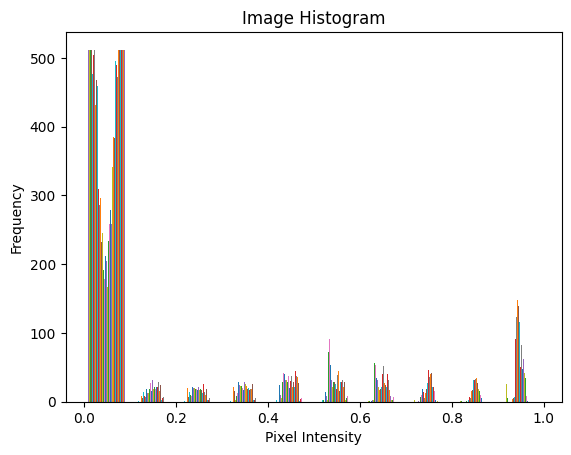

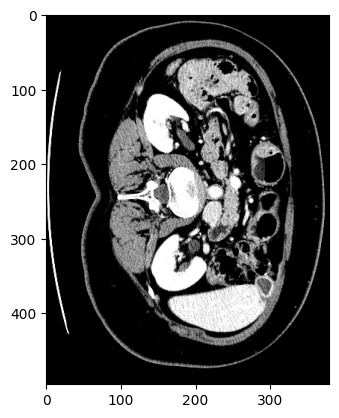

In [ ]:
# Loading image and label
result1 = LoadImaged(keys=["image", "label"])(val_files[1])
print(result1["image"].shape)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.imshow(result1["image"][:,:,30], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(result1["label"][:,:,30], cmap="gray")
plt.axis("off")
plt.show()

# Scaling Pixel Intensity
result2 = EnsureChannelFirstd(keys=["image", "label"])(result1)
# print(np.max(result2["image"][0,:,:,30]))
result = ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        )(result2)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.imshow(result["image"][0,:,:,30], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(result["label"][0,:,:,30], cmap="gray")
plt.axis("off")
plt.show()

# print(np.min(result["image"][0]))
print(result["label"].shape)
plt.imshow(result["image"][0,:,:,30], cmap="gray")

plt.show()
plt.hist(result1["image"][:,:,30])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()
plt.hist(result["image"][0,:,:,30])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()

cropped = CropForegroundd(keys=["image", "label"], source_key="image")(result)
plt.imshow(cropped["image"][0,:,:,30], cmap="gray")


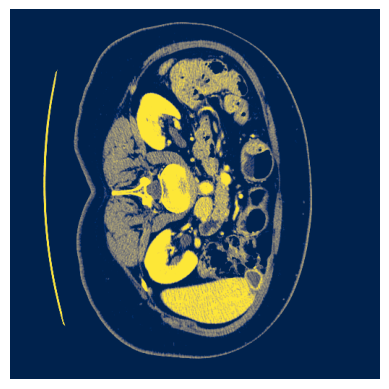

In [ ]:
# Overlaying mask over image
plt.imshow(result["image"][0,:,:,30]+result["label"][0,:,:,30], cmap="cividis")
plt.axis("off")
plt.show()

# Define CacheDataset and DataLoader for training and validation


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 11/11 [00:23<00:00,  2.14s/it]


In [ ]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 11/11 [00:22<00:00,  2.01s/it]


In [ ]:
val_files

[{'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_41.nii.gz',
  'label': '/content/drive/MyDrive/SpleenNifti/labels/spleen_41_label.nii.gz'},
 {'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_25.nii.gz',
  'label': '/content/drive/MyDrive/SpleenNifti/labels/spleen_25_label.nii.gz'},
 {'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_2.nii.gz',
  'label': '/content/drive/MyDrive/SpleenNifti/labels/spleen_2_label.nii.gz'},
 {'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_44.nii.gz',
  'label': '/content/drive/MyDrive/SpleenNifti/labels/spleen_44_label.nii.gz'},
 {'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_16.nii.gz',
  'label': '/content/drive/MyDrive/SpleenNifti/labels/spleen_16_label.nii.gz'},
 {'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_9.nii.gz',
  'label': '/content/drive/MyDrive/SpleenNifti/labels/spleen_9_label.nii.gz'},
 {'image': '/content/drive/MyDrive/SpleenNifti/images/spleen_31.nii.gz',
  'label': '/

# Create Model

- This defines a 3D U-Net model for semantic segmentation, utilizing GPU if available.

- The model architecture consists of contracting and expanding paths with specified channels and strides, enhanced by residual units.

- The training setup includes the Dice loss, Adam optimizer, and a Dice metric for evaluation, targeting multi-class segmentation with background excluded.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Training Loop

This trains a U-Net model for semantic segmentation over multiple epochs, evaluating on a validation dataset at intervals.

It tracks loss, dice metric, and saves checkpoints of the model's state, optimizer state, and training progress to monitor and resume training later.

In [ ]:
max_epochs = 100
val_interval = 2
save_dir = "/content/drive/MyDrive/SpleenNifti/ImprovedResults"

# Initialize tracking variables
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


# Training loop
for epoch in range(0, max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Validation
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(save_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

    # Save checkpoint every epoch
    checkpoint = {
        "epoch": epoch,
        "train_loss": epoch_loss_values,
        "val_dice": metric_values,
        "best_metric": best_metric,
        "best_metric_epoch": best_metric_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, os.path.join(save_dir, "my_checkpoint.pth.tar"))

----------
epoch 1/100


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


epoch 1 average loss: 0.5864
----------
epoch 2/100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

epoch 2 average loss: 0.5782


saved new best metric model
current epoch: 2 current mean dice: 0.0609
best mean dice: 0.0609 at epoch: 2
----------
epoch 3/100


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


epoch 3 average loss: 0.5608
----------
epoch 4/100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

epoch 4 average loss: 0.5624


saved new best metric model
current epoch: 4 current mean dice: 0.0703
best mean dice: 0.0703 at epoch: 4
----------
epoch 5/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


epoch 5 average loss: 0.5578
----------
epoch 6/100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

epoch 6 average loss: 0.5300


current epoch: 6 current mean dice: 0.0578
best mean dice: 0.0703 at epoch: 4
----------
epoch 7/100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


epoch 7 average loss: 0.5308
----------
epoch 8/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

epoch 8 average loss: 0.5539


saved new best metric model
current epoch: 8 current mean dice: 0.1524
best mean dice: 0.1524 at epoch: 8
----------
epoch 9/100


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


epoch 9 average loss: 0.5361
----------
epoch 10/100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

epoch 10 average loss: 0.5322


current epoch: 10 current mean dice: 0.0880
best mean dice: 0.1524 at epoch: 8
----------
epoch 11/100


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


epoch 11 average loss: 0.5231
----------
epoch 12/100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

epoch 12 average loss: 0.4984


current epoch: 12 current mean dice: 0.0453
best mean dice: 0.1524 at epoch: 8
----------
epoch 13/100


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


epoch 13 average loss: 0.4960
----------
epoch 14/100


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]

epoch 14 average loss: 0.4949


current epoch: 14 current mean dice: 0.0472
best mean dice: 0.1524 at epoch: 8
----------
epoch 15/100


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


epoch 15 average loss: 0.5013
----------
epoch 16/100


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]

epoch 16 average loss: 0.4782


current epoch: 16 current mean dice: 0.0537
best mean dice: 0.1524 at epoch: 8
----------
epoch 17/100


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


epoch 17 average loss: 0.4744
----------
epoch 18/100


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

epoch 18 average loss: 0.4747


current epoch: 18 current mean dice: 0.0923
best mean dice: 0.1524 at epoch: 8
----------
epoch 19/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


epoch 19 average loss: 0.4680
----------
epoch 20/100


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

epoch 20 average loss: 0.4571


current epoch: 20 current mean dice: 0.0526
best mean dice: 0.1524 at epoch: 8
----------
epoch 21/100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


epoch 21 average loss: 0.4419
----------
epoch 22/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

epoch 22 average loss: 0.4532


current epoch: 22 current mean dice: 0.1053
best mean dice: 0.1524 at epoch: 8
----------
epoch 23/100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


epoch 23 average loss: 0.4520
----------
epoch 24/100


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]

epoch 24 average loss: 0.4483


current epoch: 24 current mean dice: 0.0639
best mean dice: 0.1524 at epoch: 8
----------
epoch 25/100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


epoch 25 average loss: 0.4141
----------
epoch 26/100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]

epoch 26 average loss: 0.4177


current epoch: 26 current mean dice: 0.0312
best mean dice: 0.1524 at epoch: 8
----------
epoch 27/100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


epoch 27 average loss: 0.4270
----------
epoch 28/100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]

epoch 28 average loss: 0.4261


current epoch: 28 current mean dice: 0.0689
best mean dice: 0.1524 at epoch: 8
----------
epoch 29/100


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


epoch 29 average loss: 0.3962
----------
epoch 30/100


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

epoch 30 average loss: 0.3957


current epoch: 30 current mean dice: 0.0630
best mean dice: 0.1524 at epoch: 8
----------
epoch 31/100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


epoch 31 average loss: 0.3993
----------
epoch 32/100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

epoch 32 average loss: 0.3969


current epoch: 32 current mean dice: 0.0964
best mean dice: 0.1524 at epoch: 8
----------
epoch 33/100


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


epoch 33 average loss: 0.3677
----------
epoch 34/100


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

epoch 34 average loss: 0.3764


current epoch: 34 current mean dice: 0.1066
best mean dice: 0.1524 at epoch: 8
----------
epoch 35/100


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


epoch 35 average loss: 0.3579
----------
epoch 36/100


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

epoch 36 average loss: 0.3764


current epoch: 36 current mean dice: 0.1183
best mean dice: 0.1524 at epoch: 8
----------
epoch 37/100


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


epoch 37 average loss: 0.3523
----------
epoch 38/100


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

epoch 38 average loss: 0.3639


current epoch: 38 current mean dice: 0.1487
best mean dice: 0.1524 at epoch: 8
----------
epoch 39/100


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


epoch 39 average loss: 0.3484
----------
epoch 40/100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

epoch 40 average loss: 0.3383


current epoch: 40 current mean dice: 0.0841
best mean dice: 0.1524 at epoch: 8
----------
epoch 41/100


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


epoch 41 average loss: 0.3350
----------
epoch 42/100


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

epoch 42 average loss: 0.3360


current epoch: 42 current mean dice: 0.1520
best mean dice: 0.1524 at epoch: 8
----------
epoch 43/100


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


epoch 43 average loss: 0.3451
----------
epoch 44/100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]

epoch 44 average loss: 0.3470


current epoch: 44 current mean dice: 0.1021
best mean dice: 0.1524 at epoch: 8
----------
epoch 45/100


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


epoch 45 average loss: 0.3234
----------
epoch 46/100


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

epoch 46 average loss: 0.3385


saved new best metric model
current epoch: 46 current mean dice: 0.4153
best mean dice: 0.4153 at epoch: 46
----------
epoch 47/100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


epoch 47 average loss: 0.3210
----------
epoch 48/100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

epoch 48 average loss: 0.3114


current epoch: 48 current mean dice: 0.3383
best mean dice: 0.4153 at epoch: 46
----------
epoch 49/100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


epoch 49 average loss: 0.3259
----------
epoch 50/100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

epoch 50 average loss: 0.2896


current epoch: 50 current mean dice: 0.2747
best mean dice: 0.4153 at epoch: 46
----------
epoch 51/100


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


epoch 51 average loss: 0.3017
----------
epoch 52/100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

epoch 52 average loss: 0.3336


current epoch: 52 current mean dice: 0.3994
best mean dice: 0.4153 at epoch: 46
----------
epoch 53/100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


epoch 53 average loss: 0.3039
----------
epoch 54/100


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]

epoch 54 average loss: 0.2900


current epoch: 54 current mean dice: 0.3159
best mean dice: 0.4153 at epoch: 46
----------
epoch 55/100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


epoch 55 average loss: 0.2986
----------
epoch 56/100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

epoch 56 average loss: 0.3153


current epoch: 56 current mean dice: 0.1955
best mean dice: 0.4153 at epoch: 46
----------
epoch 57/100


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


epoch 57 average loss: 0.2969
----------
epoch 58/100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]

epoch 58 average loss: 0.2890


current epoch: 58 current mean dice: 0.0904
best mean dice: 0.4153 at epoch: 46
----------
epoch 59/100


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


epoch 59 average loss: 0.2971
----------
epoch 60/100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

epoch 60 average loss: 0.2973


saved new best metric model
current epoch: 60 current mean dice: 0.5783
best mean dice: 0.5783 at epoch: 60
----------
epoch 61/100


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


epoch 61 average loss: 0.2733
----------
epoch 62/100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

epoch 62 average loss: 0.2495


current epoch: 62 current mean dice: 0.2779
best mean dice: 0.5783 at epoch: 60
----------
epoch 63/100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


epoch 63 average loss: 0.3174
----------
epoch 64/100


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

epoch 64 average loss: 0.2826


saved new best metric model
current epoch: 64 current mean dice: 0.7959
best mean dice: 0.7959 at epoch: 64
----------
epoch 65/100


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


epoch 65 average loss: 0.2883
----------
epoch 66/100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]

epoch 66 average loss: 0.2312


current epoch: 66 current mean dice: 0.5086
best mean dice: 0.7959 at epoch: 64
----------
epoch 67/100


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


epoch 67 average loss: 0.2450
----------
epoch 68/100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

epoch 68 average loss: 0.2756


current epoch: 68 current mean dice: 0.7662
best mean dice: 0.7959 at epoch: 64
----------
epoch 69/100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


epoch 69 average loss: 0.2606
----------
epoch 70/100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]

epoch 70 average loss: 0.2757


saved new best metric model
current epoch: 70 current mean dice: 0.8531
best mean dice: 0.8531 at epoch: 70
----------
epoch 71/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


epoch 71 average loss: 0.2305
----------
epoch 72/100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

epoch 72 average loss: 0.2591


current epoch: 72 current mean dice: 0.8293
best mean dice: 0.8531 at epoch: 70
----------
epoch 73/100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


epoch 73 average loss: 0.2682
----------
epoch 74/100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

epoch 74 average loss: 0.2836


current epoch: 74 current mean dice: 0.6145
best mean dice: 0.8531 at epoch: 70
----------
epoch 75/100


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


epoch 75 average loss: 0.2554
----------
epoch 76/100


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

epoch 76 average loss: 0.2215


current epoch: 76 current mean dice: 0.8344
best mean dice: 0.8531 at epoch: 70
----------
epoch 77/100


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


epoch 77 average loss: 0.2675
----------
epoch 78/100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]

epoch 78 average loss: 0.2323


saved new best metric model
current epoch: 78 current mean dice: 0.8656
best mean dice: 0.8656 at epoch: 78
----------
epoch 79/100


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


epoch 79 average loss: 0.2344
----------
epoch 80/100


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

epoch 80 average loss: 0.2873


current epoch: 80 current mean dice: 0.6802
best mean dice: 0.8656 at epoch: 78
----------
epoch 81/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


epoch 81 average loss: 0.2456
----------
epoch 82/100


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

epoch 82 average loss: 0.2498


current epoch: 82 current mean dice: 0.8429
best mean dice: 0.8656 at epoch: 78
----------
epoch 83/100


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


epoch 83 average loss: 0.2517
----------
epoch 84/100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

epoch 84 average loss: 0.2261


current epoch: 84 current mean dice: 0.5836
best mean dice: 0.8656 at epoch: 78
----------
epoch 85/100


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


epoch 85 average loss: 0.2648
----------
epoch 86/100


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]

epoch 86 average loss: 0.2554


current epoch: 86 current mean dice: 0.4867
best mean dice: 0.8656 at epoch: 78
----------
epoch 87/100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


epoch 87 average loss: 0.2480
----------
epoch 88/100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

epoch 88 average loss: 0.2512


current epoch: 88 current mean dice: 0.0673
best mean dice: 0.8656 at epoch: 78
----------
epoch 89/100


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


epoch 89 average loss: 0.2656
----------
epoch 90/100


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

epoch 90 average loss: 0.2181


current epoch: 90 current mean dice: 0.7968
best mean dice: 0.8656 at epoch: 78
----------
epoch 91/100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


epoch 91 average loss: 0.2337
----------
epoch 92/100


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

epoch 92 average loss: 0.1949


saved new best metric model
current epoch: 92 current mean dice: 0.9122
best mean dice: 0.9122 at epoch: 92
----------
epoch 93/100


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


epoch 93 average loss: 0.2280
----------
epoch 94/100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

epoch 94 average loss: 0.2099


current epoch: 94 current mean dice: 0.7903
best mean dice: 0.9122 at epoch: 92
----------
epoch 95/100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


epoch 95 average loss: 0.2146
----------
epoch 96/100


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

epoch 96 average loss: 0.2419


current epoch: 96 current mean dice: 0.8903
best mean dice: 0.9122 at epoch: 92
----------
epoch 97/100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


epoch 97 average loss: 0.2147
----------
epoch 98/100


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]

epoch 98 average loss: 0.2299


current epoch: 98 current mean dice: 0.9072
best mean dice: 0.9122 at epoch: 92
----------
epoch 99/100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


epoch 99 average loss: 0.2192
----------
epoch 100/100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

epoch 100 average loss: 0.2174


current epoch: 100 current mean dice: 0.9107
best mean dice: 0.9122 at epoch: 92


In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")


train completed, best_metric: 0.9122 at epoch: 92


# Plot the loss and metric

In [ ]:
# Loading the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load("/content/drive/MyDrive/SpleenNifti/ImprovedResults/my_checkpoint.pth.tar", map_location=device)
checkpoint.keys()

dict_keys(['epoch', 'train_loss', 'val_dice', 'best_metric', 'best_metric_epoch', 'model_state_dict', 'optimizer_state_dict'])

[0.15195712447166443, 0.102142333984375, 0.4153403341770172, 0.3383242189884186, 0.2747080624103546, 0.399440735578537, 0.31586071848869324, 0.19549560546875, 0.09040269255638123, 0.5783141851425171]


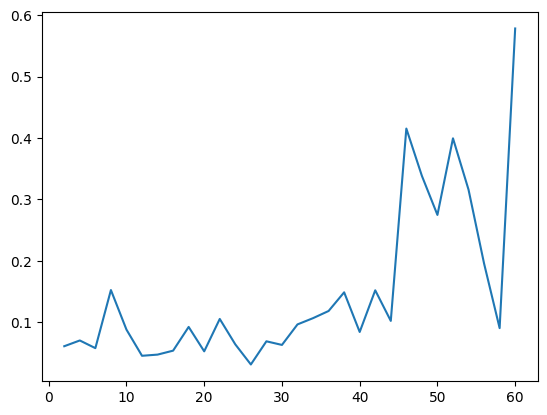

In [ ]:
val_dice = checkpoint["val_dice"]
x = [2 * (i + 1) for i in range(len(checkpoint["val_dice"][0:30]))]
y = checkpoint["val_dice"][0:30]
plt.plot(x,y)
print(val_dice[20:30])

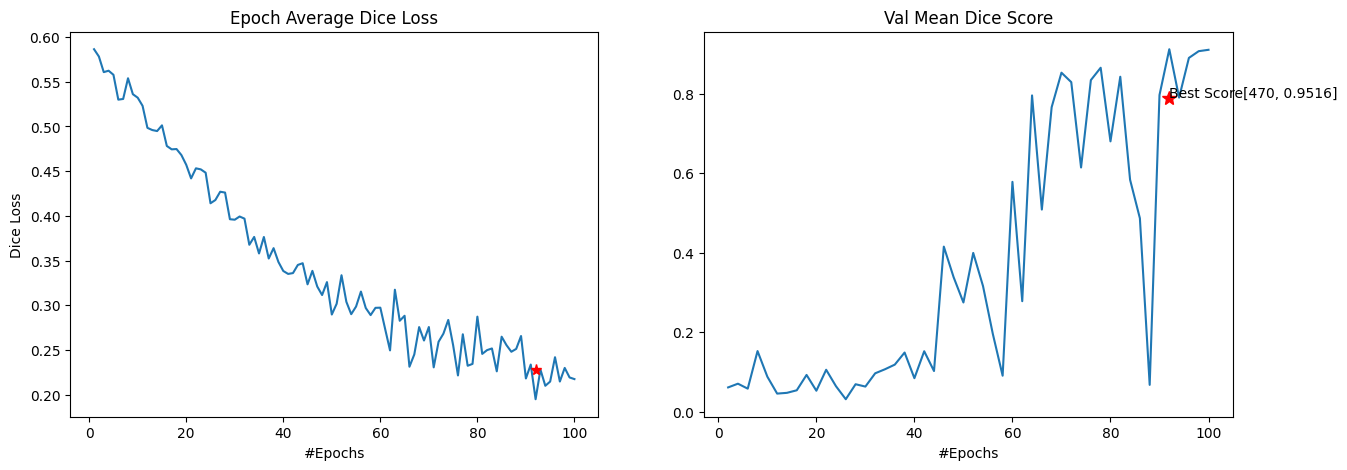

In [ ]:
val_interval = 2
plt.figure("train", (15, 5))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Dice Loss")
x = [i + 1 for i in range(len(checkpoint["train_loss"]))]
y = checkpoint["train_loss"]
plt.xlabel("#Epochs")
plt.ylabel("Dice Loss")
plt.plot(x, y)
plt.plot(checkpoint["best_metric_epoch"], checkpoint["train_loss"][checkpoint["best_metric_epoch"]], 'r*', markersize=8)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice Score")
x = [val_interval * (i + 1) for i in range(len(checkpoint["val_dice"]))]
y = checkpoint["val_dice"]
plt.xlabel("#Epochs")
plt.plot(x, y)
plt.plot(checkpoint["best_metric_epoch"], checkpoint["val_dice"][checkpoint["best_metric_epoch"]//2], 'r*', markersize=10)
plt.annotate("Best Score[470, 0.9516]", xy=(checkpoint["best_metric_epoch"], checkpoint["val_dice"][checkpoint["best_metric_epoch"]//2]))
plt.savefig("LearningCurves.png")
plt.show()

In [ ]:
checkpoint["best_metric_epoch"]

92

# Check best model output with the input image and label

This loads the trained U-Net model with the best performance checkpoint, applies it to a few validation samples using sliding window inference, and displays a side-by-side comparison of the input image, ground truth label, and model's segmentation output for a specific slice.

In [ ]:
import time

In [ ]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

NameError: name 'CacheDataset' is not defined

In [ ]:
save_dir = "/content/drive/MyDrive/SpleenNifti/ImprovedResults"

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(save_dir, "best_metric_model.pth"), map_location=device))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4

        inputs = val_data["image"].to(device)
        labels = val_data["label"].to(device)

        val_outputs = sliding_window_inference(inputs, roi_size, sw_batch_size, model)
        pred_output = torch.argmax(val_outputs, dim=1).detach().cpu()[0]
        input_image = inputs.cpu()[0, 0]
        label_image = labels.cpu()[0, 0]

        num_slices = input_image.shape[-1]

        for slice_idx in range(num_slices):
            plt.figure(figsize=(18, 6))
            plt.suptitle(f"Sample {i}, Slice {slice_idx}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.title("Image")
            plt.imshow(input_image[:, :, slice_idx], cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(label_image[:, :, slice_idx])
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(pred_output[:, :, slice_idx])
            plt.axis("off")

            plt.show()

        # Limit to first 2 samples (remove this if you want all)
        if i == 1:
            break

# Creating Animation by Overlaying Mask Over Image

This generates a video animation that combines input images, ground truth labels, and model predictions for a single volume slice, creating a dynamic visualization of the segmentation process.

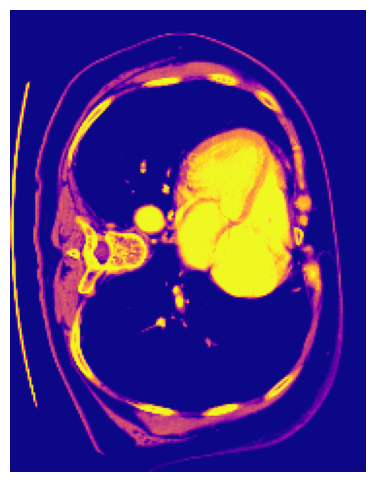

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

roi_size = (160, 160, 160)
sw_batch_size = 4
frames = []

# Get one batch from val_loader
for i, data in enumerate(val_loader):
    val_data = data
    if i == 1:
        break

# Run inference
val_outputs = sliding_window_inference(
    val_data["image"].to(device), roi_size, sw_batch_size, model
)
outputs = torch.argmax(val_outputs, dim=1)

# Move everything to CPU for visualization
input_img = val_data["image"][0, 0].cpu()
label_img = val_data["label"][0, 0].cpu()
pred_img = outputs[0].cpu()

# Build the animation
fig = plt.figure(figsize=(6, 6))
plt.axis("off")

for i in range(input_img.shape[-1]):
    blended = input_img[:, :, i] + (1.5 * label_img[:, :, i]) + (1.5 * pred_img[:, :, i])
    img = plt.imshow(blended, cmap="plasma", animated=True)
    frames.append([img])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=2000)
ani.save('movie.mp4')
plt.show()